In [1]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

In [2]:
#将tensor类型转换为图像
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

#加载图像类型，并将维度限制在512
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = tf.expand_dims(img,0)
    return img

#显示图像
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [3]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [4]:
def vgg_layers(layer_names):
    """ 返回VGG模型,其中outputs为每层的输出,返回的模型为输入图像，输出需要的每层的特征输出"""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [5]:
class StyleContentModel(tf.keras.models.Model):
    '''创建风格内容模型,首先将图像0-1之间映射到255,然后得到风格输出和内容输出
       将风格图像特征用Gram矩阵表示,然后构建每一层对应特征表示的字典并返回'''
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                        outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                    for style_name, value
                    in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [6]:
#定义内容图像和风格图像的特征层名字
content_path = './image/content.jpg'
style_path = './image/style.jpg'

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

#实例化模型作为特征提取器
extractor = StyleContentModel(style_layers, content_layers)

#归一化
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

#设置权重，风格图像权重为0.01，内容图像权重为10000，正则化图像权重为30
style_weight=1e-2
content_weight=1e4
total_variation_weight=30

#得到图像的tensor表达
content_image = load_img(content_path)
style_image = load_img(style_path)

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#得到风格图像和内容图像的特征表达
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

def style_content_loss(outputs):
    '''损失函数,获得风格图像和内容图像每层的平均损失相加,作为合成的图像'''
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                        for name in style_outputs.keys()])
    
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                            for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    return loss

#训练一个step
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_content_loss(outputs)
      #加上正则化损失
      loss += total_variation_weight*tf.image.total_variation(image)

    #计算loss和内容图像的梯度
    grad = tape.gradient(loss, image)
    #使用梯度来更新变量
    opt.apply_gradients([(grad, image)])
    #将image归一化
    image.assign(clip_0_1(image))

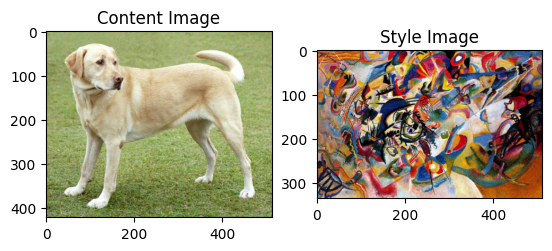

In [7]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

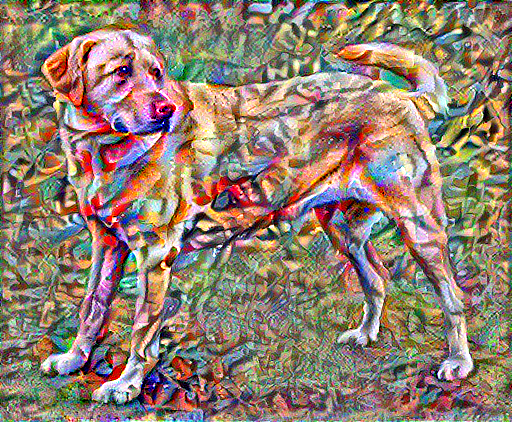

Train step: 250


In [8]:
if __name__=="__main__":
    
    image = tf.Variable(content_image)

    epochs = 5
    steps_per_epoch = 50
    step = 0
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
      display.clear_output(wait=True)
      display.display(tensor_to_image(image))
      print("Train step: {}".format(step))
      file_name = './image/stylized-image.png'
      tensor_to_image(image).save(file_name)